In [1]:
import pandas as pd 
import numpy as np

from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from utils import INPUT_SHAPE, batch_generator
import argparse
import os

from  keras import Model
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt
import keras

from keras.layers import LSTM, Lambda, Conv2D, MaxPooling2D, Dropout, Dense, Flatten, Reshape,concatenate,Input


Using TensorFlow backend.


In [2]:
def load_data():
    test_size =0.2
    data_dir = '/home/seheekim/Desktop/autonomous/cloning/data_raw'
    """
    Load training data and split it into training and validation set
    """
    #reads CSV file into a single dataframe variable
    data_df = pd.read_csv(os.path.join(os.getcwd(), data_dir, '/home/seheekim/Desktop/autonomous/cloning/data.csv'), 
                          names=['image_dir','speed','angle'])

    #yay dataframes, we can select rows and columns by their names
    #we'll store the camera images as our input data
    X = data_df['image_dir'].values
    #and our steering commands as our output data
    y = data_df['angle'].values

    #now we can split the data into a training (80), testing(20), and validation set
    #thanks scikit learn
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=test_size, random_state=0)

    return X_train, X_valid, y_train, y_valid

In [3]:
X_train, X_valid, y_train, y_valid = load_data()



print(X_train.size)

18071


In [4]:
def build_model(): 
    model = Sequential()
    model.add(Lambda(lambda x: x/127.5-1.0, input_shape=INPUT_SHAPE))
    model.add(Conv2D(24, 5, 5, activation='elu', subsample=(2, 2)))
    model.add(Conv2D(36, 5, 5, activation='elu', subsample=(2, 2)))
    model.add(Conv2D(48, 5, 5, activation='elu', subsample=(2, 2)))
    model.add(Conv2D(64, 3, 3, activation='elu'))
    model.add(Conv2D(64, 3, 3, activation='elu'))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(100, activation='elu'))
    model.add(Dense(50, activation='elu'))
    model.add(Dense(10, activation='elu'))
    model.add(keras.layers.Reshape((1, 10)))
    # First layer specifies input_shape and returns sequences
    model.add(LSTM(units=100, return_sequences=True))
    # Dropout layer to prevent overfitting
    model.add(Dropout(rate=0.1))
    # Last layer doesn't return sequences (middle layers should return sequences)
    model.add(LSTM(units=100))
    model.add(Dropout(rate=0.1))
    # Dense layer to return prediction
    model.add(Dense(1))
    model.summary()

    return model

In [5]:
def train_model(model,  X_train, X_valid, y_train, y_valid):
    save_best_only = True
    learning_rate= 1.0e-4
    data_dir= '/home/seheekim/Desktop/autonomous/cloning/data_raw'
    print(X_train.shape)
    batch_size = 40
    samples_per_epoch = 20000
    nb_epoch = 10
    checkpoint = ModelCheckpoint('doyong_model-{epoch:03d}.h5',
                                 monitor='val_loss',
                                 verbose=0,
                                 save_best_only=save_best_only,
                                 mode='auto')

    
    #gradient descent
    model.compile(loss='mean_squared_error', optimizer=Adam(lr=learning_rate))

    #Fits the model on data generated batch-by-batch by a Python generator.

    
    result =  model.fit_generator(batch_generator(data_dir, X_train, y_train, batch_size, True),
                        samples_per_epoch,
                        nb_epoch,
                        max_q_size=1,
                        validation_data=batch_generator(data_dir, X_valid, y_valid, batch_size, False),
                        nb_val_samples=len(X_valid),
                        callbacks=[checkpoint],
                        verbose=1)
    # Plot loss and save model
    plt.semilogy(result.history['loss'],label='loss')
    plt.semilogy(result.history['val_loss'],label='val_loss')
    plt.legend()

In [6]:
def main():
    """
    Load train/validation data set and train the model
    """


    #load data
    data = load_data()
    #build model
    model = build_model()
    #train model on data, it saves as model.h5 
    train_model(model, *data)

/home/walid/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), activation="elu", strides=(2, 2))`
  after removing the cwd from sys.path.
/home/walid/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), activation="elu", strides=(2, 2))`
  """
/home/walid/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (5, 5), activation="elu", strides=(2, 2))`
  
/home/walid/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="elu")`
  import sys
/home/walid/.local/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="elu")`
  


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 200, 200, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 98, 98, 24)        1824      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 47, 47, 36)        21636     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 22, 22, 48)        43248     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 20, 20, 64)        27712     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 18, 18, 64)        36928     
_________________________________________________________________
dropout_1 (Dropout)          (None, 18, 18, 64)       

/home/walid/.local/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/home/walid/.local/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., 20000, 10, validation_data=<generator..., callbacks=[<keras.ca..., verbose=1, validation_steps=4518, max_queue_size=1)`


Epoch 1/10
20000/20000 [==============================] - 8216s 411ms/step - loss: 25.2376 - val_loss: 32.2287
Epoch 2/10
20000/20000 [==============================] - 8258s 413ms/step - loss: 18.8573 - val_loss: 7.3852
Epoch 3/10
20000/20000 [==============================] - 8255s 413ms/step - loss: 16.9132 - val_loss: 5.2164
Epoch 4/10
20000/20000 [==============================] - 8215s 411ms/step - loss: 16.2246 - val_loss: 8.2676
Epoch 5/10
20000/20000 [==============================] - 8214s 411ms/step - loss: 15.5880 - val_loss: 21.6050
Epoch 6/10
20000/20000 [==============================] - 8209s 410ms/step - loss: 15.1387 - val_loss: 8.3243
Epoch 7/10
20000/20000 [==============================] - 8210s 410ms/step - loss: 14.7619 - val_loss: 3.9235
Epoch 8/10
20000/20000 [==============================] - 8213s 411ms/step - loss: 14.3424 - val_loss: 1.3600
Epoch 9/10
20000/20000 [==============================] - 8217s 411ms/step - loss: 14.2987 - val_loss: 6.9648
Epoch 10

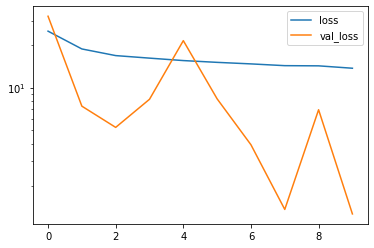

In [7]:
if __name__ == '__main__':
    main()